In [177]:
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import eugene as eu
from sklearn.metrics import r2_score
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
import seaborn as sns

In [178]:
sdata = eu.dl.read_h5sd("../../output/ray13/sequence_datum/SD_predict_RNAcomplete.h5")
sdata_set_a = sdata[:120326]
sdata_set_b = sdata[120326:]

In [305]:
a_presence_absence = np.load("/cellar/users/aklie/data/eugene/ray13/SetA_binary.npy")
b_presence_absence = np.load("/cellar/users/aklie/data/eugene/ray13/SetB_binary.npy")

# Spot check

In [192]:
from tqdm import tqdm
tqdm.pandas()
from eugene.predict._metrics import median_calc, auc_calc, calc_auc, escore

In [199]:
# Choose the task
probe_id = "RNCMPT00001"
observed = sdata_set_a[probe_id].values
preds = sdata_set_a[f"{probe_id}_predictions"].values

In [291]:
def rna_complete_metrics_apply(kmer_presence_mtx, intensities, num_kmers=None, use_calc_auc=False, verbose=True):
    df = pd.DataFrame(kmer_presence_mtx)
    y = intensities
    df_sub = df[:num_kmers]
    if verbose:
        if use_calc_auc:
            rbp_eval = df_sub.progress_apply(lambda preds: pd.Series({'Median': median_calc(preds, y), 'AUC': calc_auc(y, preds), 'E-score': escore(preds, y, use_calc_auc=True)}), axis=1)
        else:
            rbp_eval = df_sub.progress_apply(lambda preds: pd.Series({'Median': median_calc(preds, y), 'AUC': auc_calc(preds, y), 'E-score': escore(preds, y)}), axis=1)
    else:
        if use_calc_auc:
            rbp_eval = df_sub.apply(lambda preds: pd.Series({'Median': median_calc(preds, y), 'AUC': calc_auc(y, preds), 'E-score': escore(preds, y, use_calc_auc=True)}), axis=1)
        else:
            rbp_eval = df_sub.apply(lambda preds: pd.Series({'Median': median_calc(preds, y), 'AUC': auc_calc(preds, y), 'E-score': escore(preds, y)}), axis=1)
    rbp_eval["Z-score"] = (rbp_eval["Median"] - np.mean(rbp_eval["Median"])) / np.std(rbp_eval["Median"], ddof=1)
    return rbp_eval["Z-score"].values, rbp_eval["AUC"].values, rbp_eval["E-score"].values, 

In [292]:
metr = rna_complete_metrics_apply(a_presence_absence, observed, num_kmers=100, verbose=False)

In [293]:
metr = rna_complete_metrics_apply(a_presence_absence, observed, num_kmers=100, verbose=True)

100%|██████████| 100/100 [00:05<00:00, 19.76it/s]


In [294]:
def column_rnac_metrics_apply(sdata, kmer_presence_mtx, probe_id, n_kmers=None, return_cors=False, use_calc_auc=False, verbose=True):
    observed = sdata[probe_id].values
    preds = sdata[f"{probe_id}_predictions"].values
    
    # Get zscores, aucs and escores from observed intensities
    observed_zscores, observed_aucs, observed_escores = rna_complete_metrics_apply(kmer_presence_mtx, observed, num_kmers=n_kmers, verbose=verbose, use_calc_auc=use_calc_auc)

    # Get zscores, aucs, and escores from predicted intensities
    preds_zscores, preds_aucs, preds_escores = rna_complete_metrics_apply(kmer_presence_mtx, preds, num_kmers=n_kmers, verbose=verbose, use_calc_auc=use_calc_auc)
    
    # Z-scores
    zscore_pearson = pearsonr(preds_zscores, observed_zscores)[0]
    zscore_spearman = spearmanr(preds_zscores, observed_zscores).correlation

    # AUCs
    auc_pearson = pearsonr(preds_aucs, observed_aucs)[0]
    auc_spearman = spearmanr(preds_aucs, observed_aucs).correlation

    # E-scores
    escore_pearson = pearsonr(preds_escores, observed_escores)[0]
    escore_spearman = spearmanr(preds_escores, observed_escores).correlation

    # Intensities
    intensity_pearson = pearsonr(observed, preds)[0]
    intensity_spearman = spearmanr(observed, preds).correlation
    
    if return_cors:
        pearson = {"Z-score": zscore_pearson, "AUC": auc_pearson, "E-score": escore_pearson, "Intensity": intensity_pearson}
        spearman = {"Z-score": zscore_spearman, "AUC": auc_spearman, "E-score": escore_spearman, "Intensity": intensity_spearman}
        return pearson, spearman
    
    fig, ax = plt.subplots(1, 4, figsize=(16, 4))
    ax[0].scatter(observed_zscores, preds_zscores)
    ax[0].set_title("Z-scores")
    ax[0].set_xlabel("Observed")
    ax[0].set_ylabel("Predicted")
    ax[0].text(0.75, 0.05, "r=" + str(round(zscore_pearson, 2)) + "\nrho=" + str(round(zscore_spearman, 2)), transform=ax[0].transAxes)

    ax[1].scatter(observed_aucs, preds_aucs)
    ax[1].set_title("AUCs")
    ax[1].set_xlabel("Observed")
    ax[1].set_ylabel("Predicted")
    ax[1].text(0.75, 0.05, "r=" + str(round(auc_pearson, 2)) + "\nrho=" + str(round(auc_spearman, 2)), transform=ax[1].transAxes)

    ax[2].scatter(observed_escores, preds_escores)
    ax[2].set_title("E-scores")
    ax[2].set_xlabel("Observed")
    ax[2].set_ylabel("Predicted")
    ax[2].text(0.75, 0.05, "r=" + str(round(escore_pearson, 2)) + "\nrho=" + str(round(escore_spearman, 2)), transform=ax[2].transAxes)

    ax[3].scatter(observed, preds)
    ax[3].set_title("Intensities")
    ax[3].set_xlabel("Observed")
    ax[3].set_ylabel("Predicted")
    ax[3].text(0.75, 0.05, "r=" + str(round(intensity_pearson, 2)) + "\nrho=" + str(round(intensity_spearman, 2)), transform=ax[3].transAxes)

    plt.tight_layout()

100%|██████████| 100/100 [00:05<00:00, 19.47it/s]


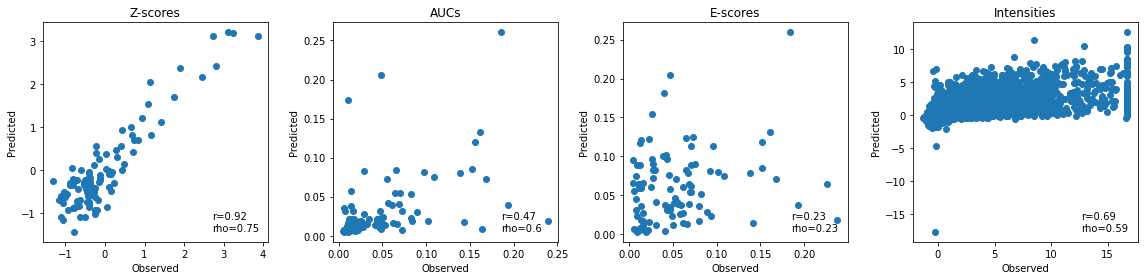

In [295]:
column_rnac_metrics_apply(sdata=sdata_set_a, kmer_presence_mtx=a_presence_absence, probe_id=probe_id, n_kmers=100, verbose=True)

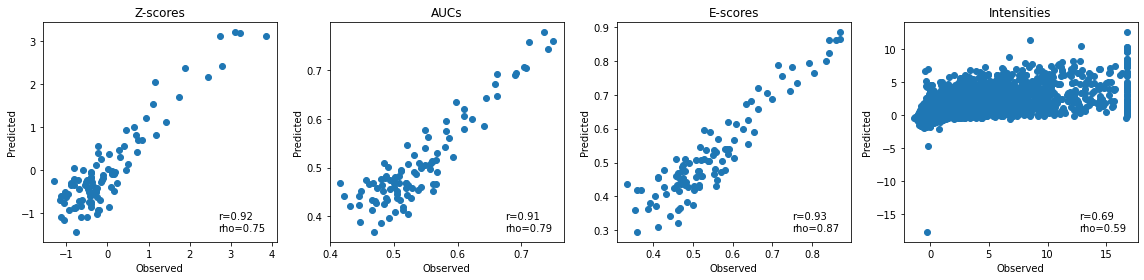

In [296]:
column_rnac_metrics_apply(sdata=sdata_set_a, kmer_presence_mtx=a_presence_absence, probe_id=probe_id, n_kmers=100, use_calc_auc=True, verbose=False)

In [297]:
from tqdm.auto import tqdm
def summarize_rbps_apply(sdata, kmer_presence_mtx, probe_ids, n_kmers=100, verbose=False, use_calc_auc=False):
    spearman_summary = pd.DataFrame()
    pearson_summary = pd.DataFrame()
    for i, probe_id in tqdm(enumerate(probe_ids), desc="Evaluating probes", total=len(probe_ids)):
        rs, rhos = column_rnac_metrics_apply(sdata, kmer_presence_mtx, probe_id=probe_id, n_kmers=n_kmers, return_cors=True, verbose=verbose, use_calc_auc=use_calc_auc)
        pearson_summary = pd.concat([pearson_summary, pd.DataFrame(rs, index=[probe_id])], axis=0)
        spearman_summary = pd.concat([spearman_summary, pd.DataFrame(rhos, index=[probe_id])], axis=0)
    return pearson_summary, spearman_summary

In [303]:
all_probe_ids = sdata_set_b.seqs_annot.columns[~sdata_set_b.seqs_annot.columns.str.contains("predictions")][:-1]

In [307]:
pearson_df, spearman_df = summarize_rbps_apply(sdata_set_b, b_presence_absence, all_probe_ids, n_kmers=None, use_calc_auc=True, verbose=True)

Evaluating probes:   0%|          | 0/236 [00:00<?, ?it/s]


  0%|          | 62/16384 [00:14<1:05:22,  4.16it/s]


KeyboardInterrupt: 

In [300]:
pearson_long = pearson_df.reset_index().melt(id_vars="index", value_name="Pearson", var_name="Metric").rename({"index":"RBP"}, axis=1)
spearman_long = spearman_df.reset_index().melt(id_vars="index", value_name="Spearman", var_name="Metric").rename({"index":"RBP"}, axis=1)

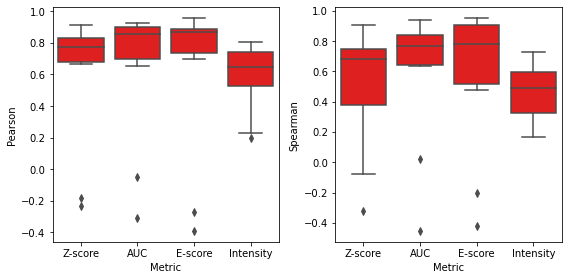

In [301]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
sns.boxplot(data=pearson_long, x="Metric", y="Pearson", color="red", ax=ax[0])
sns.boxplot(data=spearman_long, x="Metric", y="Spearman", color="red", ax=ax[1])
plt.tight_layout()

In [ ]:
def rna_complete(kmer_presence_mtx, intensities, num_kmers=None, use_calc_auc=False, verbose=True):
    y = intensities
    num_kmers = len(kmer_presence_mtx) if num_kmers is None else num_kmers
    kmer_presence_mtx = kmer_presence_mtx[:num_kmers]
    preds = kmer_presence
        kmer_medians.append(median_calc(preds=preds, y=y))
        if use_calc_auc:
            kmer_aucs.append(calc_auc(y, preds))
        else:
            kmer_aucs.append(auc_calc(preds=preds, y=y))
        kmer_escores.append(escore(preds=preds, y=y, use_calc_auc=use_calc_auc))
    kmer_medians, kmer_aucs, kmer_escore = np.array(kmer_medians), np.array(kmer_aucs), np.array(kmer_escores)
    kmer_zscores = (kmer_medians - np.mean(kmer_medians))/np.std(kmer_medians, ddof=1)
    return kmer_zscores, kmer_aucs, kmer_escores

In [183]:
def rna_complete_metrics_2(kmer_presence_mtx, intensities, num_kmers=None, use_calc_auc=False, verbose=True):
    y = intensities
    num_kmers = len(kmer_presence_mtx) if num_kmers is None else num_kmers
    kmer_presence_mtx = kmer_presence_mtx[:num_kmers]
    kmer_medians, kmer_aucs, kmer_escores = [], [], []
    for i, kmer_presence in tqdm(enumerate(kmer_presence_mtx), desc="Scoring k-mers", total=len(kmer_presence_mtx), disable = not verbose):
        preds = kmer_presence
        kmer_medians.append(median_calc(preds=preds, y=y))
        if use_calc_auc:
            kmer_aucs.append(calc_auc(y, preds))
        else:
            kmer_aucs.append(auc_calc(preds=preds, y=y))
        kmer_escores.append(escore(preds=preds, y=y, use_calc_auc=use_calc_auc))
    kmer_medians, kmer_aucs, kmer_escore = np.array(kmer_medians), np.array(kmer_aucs), np.array(kmer_escores)
    kmer_zscores = (kmer_medians - np.mean(kmer_medians))/np.std(kmer_medians, ddof=1)
    return kmer_zscores, kmer_aucs, kmer_escores

In [175]:
def column_rnac_metrics(sdata, kmer_presence_mtx, probe_id, n_kmers=None, return_cors=False, verbose=True, use_calc_auc=False):
    observed = sdata[probe_id].values
    preds = sdata[f"{probe_id}_predictions"].values
    
    # Get zscores, aucs and escores from observed intensities
    observed_zscores, observed_aucs, observed_escores = rna_complete_metrics_2(kmer_presence_mtx, observed, num_kmers=n_kmers, verbose=verbose, use_calc_auc=use_calc_auc)

    # Get zscores, aucs, and escores from predicted intensities
    preds_zscores, preds_aucs, preds_escores = rna_complete_metrics_2(kmer_presence_mtx, preds, num_kmers=n_kmers, verbose=verbose, use_calc_auc=use_calc_auc)
    
    # Z-scores
    zscore_pearson = pearsonr(preds_zscores, observed_zscores)[0]
    zscore_spearman = spearmanr(preds_zscores, observed_zscores).correlation

    # AUCs
    auc_pearson = pearsonr(preds_aucs, observed_aucs)[0]
    auc_spearman = spearmanr(preds_aucs, observed_aucs).correlation

    # E-scores
    escore_pearson = pearsonr(preds_escores, observed_escores)[0]
    escore_spearman = spearmanr(preds_escores, observed_escores).correlation

    # Intensities
    intensity_pearson = pearsonr(observed, preds)[0]
    intensity_spearman = spearmanr(observed, preds).correlation
    
    if return_cors:
        pearson = {"Z-score": zscore_pearson, "AUC": auc_pearson, "E-score": escore_pearson, "Intensity": intensity_pearson}
        spearman = {"Z-score": zscore_spearman, "AUC": auc_spearman, "E-score": escore_spearman, "Intensity": intensity_spearman}
        return pearson, spearman
    
    fig, ax = plt.subplots(1, 4, figsize=(16, 4))
    ax[0].scatter(observed_zscores, preds_zscores)
    ax[0].set_title("Z-scores")
    ax[0].set_xlabel("Observed")
    ax[0].set_ylabel("Predicted")
    ax[0].text(0.75, 0.05, "r=" + str(round(zscore_pearson, 2)) + "\nrho=" + str(round(zscore_spearman, 2)), transform=ax[0].transAxes)

    ax[1].scatter(observed_aucs, preds_aucs)
    ax[1].set_title("AUCs")
    ax[1].set_xlabel("Observed")
    ax[1].set_ylabel("Predicted")
    ax[1].text(0.75, 0.05, "r=" + str(round(auc_pearson, 2)) + "\nrho=" + str(round(auc_spearman, 2)), transform=ax[1].transAxes)

    ax[2].scatter(observed_escores, preds_escores)
    ax[2].set_title("E-scores")
    ax[2].set_xlabel("Observed")
    ax[2].set_ylabel("Predicted")
    ax[2].text(0.75, 0.05, "r=" + str(round(escore_pearson, 2)) + "\nrho=" + str(round(escore_spearman, 2)), transform=ax[2].transAxes)

    ax[3].scatter(observed, preds)
    ax[3].set_title("Intensities")
    ax[3].set_xlabel("Observed")
    ax[3].set_ylabel("Predicted")
    ax[3].text(0.75, 0.05, "r=" + str(round(intensity_pearson, 2)) + "\nrho=" + str(round(intensity_spearman, 2)), transform=ax[3].transAxes)

    plt.tight_layout()

SyntaxError: invalid syntax (1524864938.py, line 1)

In [164]:
# Choose the task
probe_id = "RNCMPT00001"
observed = sdata[probe_id].values
preds = sdata[f"{probe_id}_predictions"].values

Scoring k-mers:   0%|          | 0/10 [00:00<?, ?it/s]

HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE


Scoring k-mers:   0%|          | 0/10 [00:00<?, ?it/s]

HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE


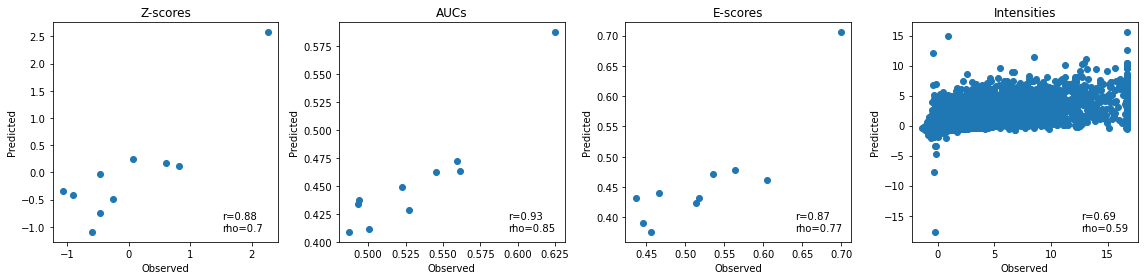

In [165]:
evaluate_rbp(probe_id, sdata.seqs, n_kmers=10, verbose=True, use_calc_auc=True)

In [166]:
from tqdm.auto import tqdm
def summarize_rbps(probe_ids, seqs, n_kmers=100, verbose=False, use_calc_auc=False):
    spearman_summary = pd.DataFrame()
    pearson_summary = pd.DataFrame()
    for i, probe_id in tqdm(enumerate(probe_ids), desc="Evaluating probes", total=len(probe_ids)):
        rs, rhos = evaluate_rbp(probe_id, sdata.seqs, n_kmers=n_kmers, return_cors=True, verbose=verbose, use_calc_auc=use_calc_auc)
        pearson_summary = pd.concat([pearson_summary, pd.DataFrame(rs, index=[probe_id])], axis=0)
        spearman_summary = pd.concat([spearman_summary, pd.DataFrame(rhos, index=[probe_id])], axis=0)
    return pearson_summary, spearman_summary

In [167]:
all_probe_ids = sdata.seqs_annot.columns[~sdata.seqs_annot.columns.str.contains("predictions")][:-1]

In [169]:
pearson_df, spearman_df = summarize_rbps(all_probe_ids[:10], sdata.seqs, n_kmers=5, use_calc_auc=True)

Evaluating probes:   0%|          | 0/10 [00:00<?, ?it/s]

In [171]:
pearson_long = pearson_df.reset_index().melt(id_vars="index", value_name="Pearson", var_name="Metric").rename({"index":"RBP"}, axis=1)
spearman_long = spearman_df.reset_index().melt(id_vars="index", value_name="Spearman", var_name="Metric").rename({"index":"RBP"}, axis=1)

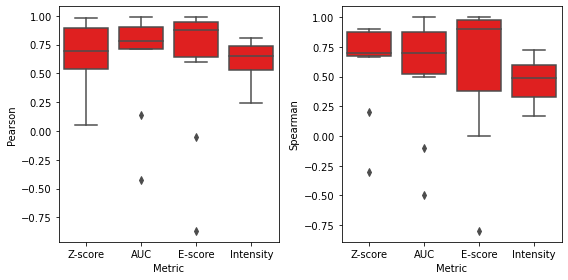

In [173]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
sns.boxplot(data=pearson_long, x="Metric", y="Pearson", color="red", ax=ax[0])
sns.boxplot(data=spearman_long, x="Metric", y="Spearman", color="red", ax=ax[1])
plt.tight_layout()

<AxesSubplot:xlabel='Metric', ylabel='Spearman'>

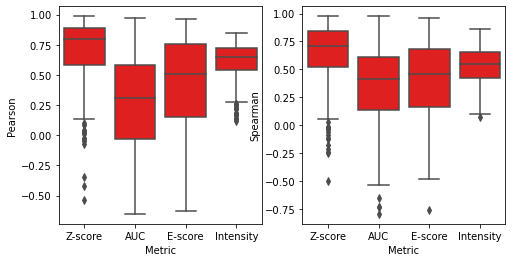

In [161]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
sns.boxplot(data=pearson_long, x="Metric", y="Pearson", color="red", ax=ax[0])
sns.boxplot(data=spearman_long, x="Metric", y="Spearman", color="red", ax=ax[1])

---

# Scratch

## Developing evaluate RBP

In [ ]:
def evaluate_rbp(sdata, probe_id, n_kmers=100, return_cors=False, verbose=True, use_calc_auc=False):
    seqs = sdata.seqs
    observed = sdata[probe_id].values
    preds = sdata[f"{probe_id}_predictions"].values
    
    # Get zscores, aucs and escores from observed intensities
    observed_zscores, observed_aucs, observed_escores = eu.predict.rna_complete_metrics(seqs, observed, num_kmers=n_kmers, verbose=verbose, use_calc_auc=use_calc_auc)

    # Get zscores, aucs, and escores from predicted intensities
    preds_zscores, preds_aucs, preds_escores = eu.predict.rna_complete_metrics(seqs, preds, num_kmers=n_kmers, verbose=verbose, use_calc_auc=use_calc_auc)
    
    # Z-scores
    zscore_pearson = pearsonr(preds_zscores, observed_zscores)[0]
    zscore_spearman = spearmanr(preds_zscores, observed_zscores).correlation

    # AUCs
    auc_pearson = pearsonr(preds_aucs, observed_aucs)[0]
    auc_spearman = spearmanr(preds_aucs, observed_aucs).correlation

    # E-scores
    escore_pearson = pearsonr(preds_escores, observed_escores)[0]
    escore_spearman = spearmanr(preds_escores, observed_escores).correlation

    # Intensities
    intensity_pearson = pearsonr(observed, preds)[0]
    intensity_spearman = spearmanr(observed, preds).correlation
    
    if return_cors:
        pearson = {"Z-score": zscore_pearson, "AUC": auc_pearson, "E-score": escore_pearson, "Intensity": intensity_pearson}
        spearman = {"Z-score": zscore_spearman, "AUC": auc_spearman, "E-score": escore_spearman, "Intensity": intensity_spearman}
        return pearson, spearman
    
    fig, ax = plt.subplots(1, 4, figsize=(16, 4))
    ax[0].scatter(observed_zscores, preds_zscores)
    ax[0].set_title("Z-scores")
    ax[0].set_xlabel("Observed")
    ax[0].set_ylabel("Predicted")
    ax[0].text(0.75, 0.05, "r=" + str(round(zscore_pearson, 2)) + "\nrho=" + str(round(zscore_spearman, 2)), transform=ax[0].transAxes)

    ax[1].scatter(observed_aucs, preds_aucs)
    ax[1].set_title("AUCs")
    ax[1].set_xlabel("Observed")
    ax[1].set_ylabel("Predicted")
    ax[1].text(0.75, 0.05, "r=" + str(round(auc_pearson, 2)) + "\nrho=" + str(round(auc_spearman, 2)), transform=ax[1].transAxes)

    ax[2].scatter(observed_escores, preds_escores)
    ax[2].set_title("E-scores")
    ax[2].set_xlabel("Observed")
    ax[2].set_ylabel("Predicted")
    ax[2].text(0.75, 0.05, "r=" + str(round(escore_pearson, 2)) + "\nrho=" + str(round(escore_spearman, 2)), transform=ax[2].transAxes)

    ax[3].scatter(observed, preds)
    ax[3].set_title("Intensities")
    ax[3].set_xlabel("Observed")
    ax[3].set_ylabel("Predicted")
    ax[3].text(0.75, 0.05, "r=" + str(round(intensity_pearson, 2)) + "\nrho=" + str(round(intensity_spearman, 2)), transform=ax[3].transAxes)

    plt.tight_layout()

In [90]:
# Get zscores, aucs and escores from observed intensities
observed_zscores, observed_aucs, observed_escores = eu.predict.rna_complete_metrics(sdata.seqs, observed, num_kmers=100)

# Get zscores, aucs, and escores from predicted intensities
db_zscores, db_aucs, db_escores = eu.predict.rna_complete_metrics(sdata.seqs, preds, num_kmers=100)

# Z-scores
zscore_pearson = pearsonr(db_zscores, observed_zscores)[0]
zscore_spearman = spearmanr(db_zscores, observed_zscores).correlation

# AUCs
auc_pearson = pearsonr(db_aucs, observed_aucs)[0]
auc_spearman = spearmanr(db_aucs, observed_aucs).correlation

# E-scores
escore_pearson = pearsonr(db_escores, observed_escores)[0]
escore_spearman = spearmanr(db_escores, observed_escores).correlation

# Intensities
intensity_pearson = pearsonr(observed, preds)[0]
intensity_spearman = spearmanr(observed, preds).correlation

fig, ax = plt.subplots(1, 4, figsize=(16, 4))

ax[0].scatter(observed_zscores, db_zscores)
ax[0].set_title("Z-scores")
ax[0].set_xlabel("Observed")
ax[0].set_ylabel("Predicted")
ax[0].text(0.75, 0.05, "r=" + str(round(zscore_pearson, 2)) + "\nrho=" + str(round(zscore_spearman, 2)), transform=ax[0].transAxes)

ax[1].scatter(observed_aucs, db_aucs)
ax[1].set_title("AUCs")
ax[1].set_xlabel("Observed")
ax[1].set_ylabel("Predicted")
ax[1].text(0.75, 0.05, "r=" + str(round(auc_pearson, 2)) + "\nrho=" + str(round(auc_spearman, 2)), transform=ax[1].transAxes)

ax[2].scatter(observed_escores, db_escores)
ax[2].set_title("E-scores")
ax[2].set_xlabel("Observed")
ax[2].set_ylabel("Predicted")
ax[2].text(0.75, 0.05, "r=" + str(round(escore_pearson, 2)) + "\nrho=" + str(round(escore_spearman, 2)), transform=ax[2].transAxes)

ax[3].scatter(observed, preds)
ax[3].set_title("Intensities")
ax[3].set_xlabel("Observed")
ax[3].set_ylabel("Predicted")
ax[3].text(0.75, 0.05, "r=" + str(round(intensity_pearson, 2)) + "\nrho=" + str(round(intensity_spearman, 2)), transform=ax[3].transAxes)

plt.tight_layout()

In [ ]:
df = pd.DataFrame(a_presence_absence)
df_sub = df[:100]
rbp_eval = df_sub.progress_apply(lambda x: pd.Series({'Median': median_calc(x, preds), 'AUC': auc_calc(x, preds), 'E-score': escore(x, preds)}), axis=1)
rbp_eval["Z-score"] = (rbp_eval["Median"] - np.mean(rbp_eval["Median"])) / np.std(rbp_eval["Median"], ddof=1)
rbp_eval